In [25]:
from scipy.linalg import solve
from scipy.special import erf as erf
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
import os, pickle
data_dir = '.'

In [26]:
# max number of st/00 st/01 .. chunks to use
max_i = 1
# person
subject = 1
# seconds offset between movie and brain data
lag = 1
# maximum number of time points to use
truncate = 200
# fraction of data that is training
train_frac = 0.8

movie_data = ['' for _ in range(max_i)]
for i in range(max_i):
    objects_file = os.path.join(data_dir, 'st', '%02i_objects.pkl' % (i, ))
    with open(objects_file, 'rb') as f:
        movie_data[i] = pickle.load(f)

brain_data = [
    np.load(
        os.path.join(data_dir, 'subject_%i' % (subject, ), 'rt', '%02i.npy' % (
            i, ))) for i in range(max_i)
]
brain_data = np.hstack(brain_data)
complete_vox = np.isclose(np.isnan(brain_data).sum(1), 0)
brain_data = brain_data[complete_vox]

In [27]:
objects = [d for l in movie_data for d in l]
unique_objects = np.unique([k for d in objects for k in d])
n_frames = len(objects)
n_unique_objects = unique_objects.shape[0]
object_index = dict(zip(unique_objects, range(n_unique_objects)))

In [8]:
confidence = np.zeros((n_unique_objects, n_frames))
for frame, d in enumerate(objects):
    for o, c in d.items():
        confidence[object_index[o], frame] = c
barcode = confidence.astype(bool)

chair = confidence[object_index['chair']]
chair_mean = np.array([x.mean() for x in np.split(chair, n_frames / 15)])

chair_mean = np.roll(chair_mean, lag)
x = np.vstack((chair_mean, brain_data))
x = x[:, lag:truncate]

split = int(x.shape[1] * train_frac)
x_train = x[:, :split]
x_test = x[:, split:]

# n, T = 20, int(1e4)
n, T = x_train.shape
dt = 1.
l = np.int(np.ceil(T / dt))
sqrt_dt = np.sqrt(dt)
sqrt_2 = np.sqrt(2)
rat = sqrt_dt / sqrt_2

In [24]:
inv_map = {v: k for k, v in object_index.items()}
for i in range(len(barcode)):
    if barcode[i].mean() >= .2:
        print(inv_map[i], barcode[i].mean())

book 0.27125
chair 0.4713333333333333
dining table 0.20508333333333334
person 0.99
tie 0.24858333333333332
tv 0.249
umbrella 0.26408333333333334


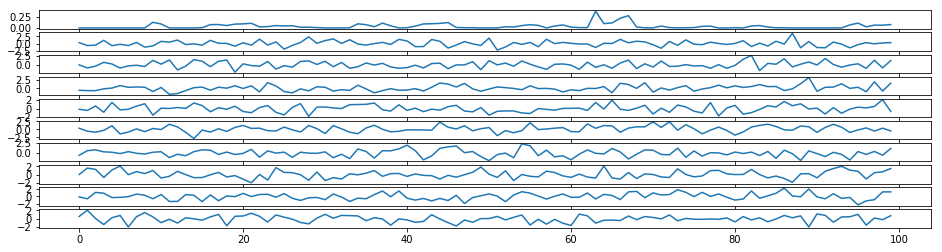

In [5]:
fig, ax = plt.subplots(10, 1, figsize=(16, 4))
for i in range(10):
    ax[i].plot(x[i, :100])
plt.show()
plt.close()

In [ ]:
x1, x2 = x_train[:, :-1], x_train[:, 1:]
sign_dx = np.sign(np.diff(x_train))
mean_x = x_train.mean(1)
cov_x = np.cov(x_train)
x1_mean0 = x1 - mean_x[:, np.newaxis]


def fit(i, iters=10):
    wi = np.zeros(n)
    wi[i] = 1

    # erf_last = erf(x1[i] * rat) + 1
    erf_last = erf(x1[i]) + 1

    e = []

    for it in range(iters):

        h = wi.dot(x1)

        # erf_next = erf(h * rat)
        erf_next = erf(h)
        ei = np.linalg.norm(erf_next - erf_last)
        e.append(ei)
        print(i, it, ei)
        if ei * ei < 1e-5:
            break
        erf_last = erf_next.copy()

        h *= sign_dx[i] / erf_next

        wi = solve(cov_x, x1_mean0.dot(h) / (l - 1))

    return wi, e[1:]


pool = mp.Pool(processes=mp.cpu_count())
res = pool.map(fit, range(n))
pool.close()
pool.terminate()
pool.join()

w = np.empty((n, n))
w = np.hstack([r[0] for r in res]) / rat
e = [r[1] for r in res]

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].matshow(w, cmap='seismic', aspect='equal')
for ei in e:
    ax[1].plot(ei)
plt.show()